# Using pre trained BERT from hugging face + LRC head for fine tuning

## Task will be sentiment analysis of IMDB movie reviews

# Load data

In [1]:
!pip install transformers datasets

In [3]:
from datasets import load_dataset

ds = load_dataset("stanfordnlp/imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})


# Tokenization

In [5]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [6]:
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

In [7]:
tokenized_dataset = ds.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [8]:
tokenized_train = tokenized_dataset["train"].remove_columns(["text"])
tokenized_test = tokenized_dataset["test"].remove_columns(["text"])

In [9]:
from transformers import BertModel, BertPreTrainedModel
import torch.nn as nn

class BertForSequenceClassification(BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.init_weights()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        logits = self.classifier(pooled_output)
        return logits

In [10]:
from transformers import BertConfig

config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)  # Assuming binary classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Convert to tensors

In [11]:
from torch.utils.data import TensorDataset, DataLoader
import torch

train_input_ids = tokenized_train["input_ids"]
train_attention_mask = tokenized_train["attention_mask"]
train_labels = tokenized_train["label"]

test_input_ids = tokenized_test["input_ids"]
test_attention_mask = tokenized_test["attention_mask"]
test_labels = tokenized_test["label"]

train_dataset = TensorDataset(torch.tensor(train_input_ids),
                              torch.tensor(train_attention_mask),
                              torch.tensor(train_labels))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(torch.tensor(test_input_ids),
                             torch.tensor(test_attention_mask),
                             torch.tensor(test_labels))
test_dataloader = DataLoader(test_dataset, batch_size=32)

Load optimizer and loss function

In [12]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fine-tuning with labels

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

In [ ]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 1

for epoch in range(num_epochs):
    model.train()
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True)
    for batch in progress_bar:
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update progress bar description with current loss
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

Test model performance

In [16]:
import torch
from tqdm import tqdm

model.eval()

all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Making predictions"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Making predictions: 100%|██████████| 782/782 [11:31<00:00,  1.13it/s]


NameError: name 'np' is not defined

In [21]:
import torch
from tqdm import tqdm
import numpy as np

model.eval()

all_probs = []
all_predictions = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Making predictions"):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]
        
        outputs = model(input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
        
        # For binary classification, we only need probabilities for one class
        probs = probabilities[:, 1].cpu().numpy()  # Assuming class 1 is the positive class
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        
        all_probs.extend(probs)
        all_predictions.extend(predictions)
        all_labels.extend(labels.cpu().numpy())

all_probs = np.array(all_probs)
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

Making predictions: 100%|██████████| 782/782 [11:29<00:00,  1.13it/s]


In [22]:
# Calculate accuracy
accuracy = (all_predictions == all_labels).mean()
print(f"Test Accuracy: {accuracy:.4f}")

# More detailed metrics
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions))

print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_predictions))

Test Accuracy: 0.9364

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     12500
           1       0.95      0.92      0.94     12500

    accuracy                           0.94     25000
   macro avg       0.94      0.94      0.94     25000
weighted avg       0.94      0.94      0.94     25000


Confusion Matrix:
[[11849   651]
 [  940 11560]]


AUROC calculation + plot

In [23]:
from sklearn.metrics import roc_auc_score

auroc = roc_auc_score(all_labels, all_probs)
print(f"AUROC: {auroc:.4f}")

AUROC: 0.9838


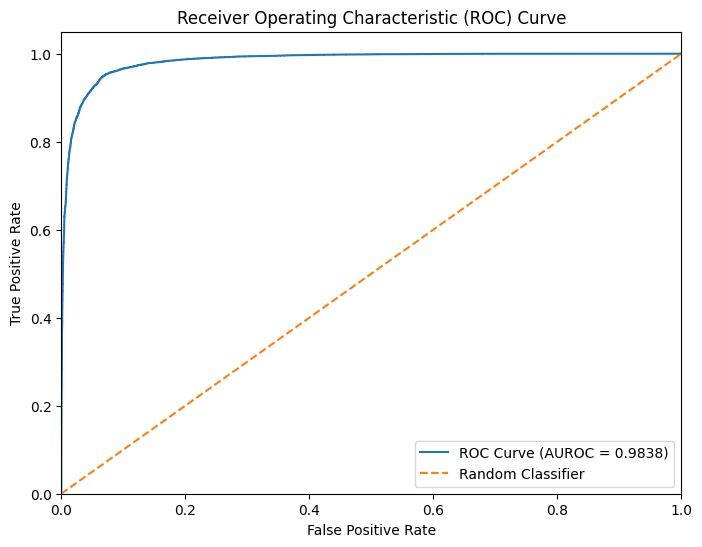

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUROC = {auroc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()